In [22]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
import statistics
import seaborn as sns
import tensorflow as tf
import pickle
from scipy.stats import pearsonr
import copy
import math
from tqdm import tqdm

In [23]:
class NeuralNet(nn.Module):
    """
    Neural network meta model
    """

    def __init__(self, input_dim, intermediate_dims=(20, 40, 20), dropout=0.9):
        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims
        # define the number of hidden layers
        self.hidden_num = len(intermediate_dims) + 1
        self.dropout = dropout
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.dropout_layer = nn.Dropout(self.dropout)

        # define the first hidden layer
        exec("self.hidden_layer1 = nn.Linear({}, {})".format(input_dim, intermediate_dims[0]))
        exec("self.dropout1 = nn.Dropout(p={})".format(dropout))

        # define the following hidden layers except for the last layer
        for i in range(len(intermediate_dims) - 1):
            exec(
                "self.hidden_layer{} = nn.Linear({}, {})".format(i + 2, intermediate_dims[i], intermediate_dims[i + 1]))
            exec("self.dropout{} = nn.Dropout(p={})".format(i + 2, dropout))
        # define the last hidden layer
        exec("self.hidden_layer_last = nn.Linear({}, 1)".format(intermediate_dims[-1]))

    def forward(self, x):
        # use loop to determine the next hidden layers

        for i in range(self.hidden_num - 1):
            x = eval("self.hidden_layer{}(x)".format(1 + i))
            x = F.relu(x)
            x = eval('self.dropout{}(x)'.format(i + 1))

        y = self.hidden_layer_last(x)
        #y = torch.tanh(y)

        return y

    def __repr__(self):
        return "NeuralNet(input_dim={}, output_dim={}, intermediate_dims={}, dropout={})".format(
            self.input_dim.__repr__(), self.output_dim.__repr__(),
            self.intermediate_dims.__repr__(), self.dropout.__repr__()
        )
    def plot(self, train_loss, validation_loss, train_std, val_std, num_epochs, title=''):
        #plot the training graph
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss, label='Train Loss', color='blue')
        if train_std:
            plt.fill_between(epochs, np.array(train_loss) - np.array(train_std), np.array(train_loss) + np.array(train_std), color='blue', alpha=0.2)
        plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
        if val_std:
            plt.fill_between(epochs, np.array(validation_loss) - np.array(val_std), np.array(validation_loss) + np.array(val_std), color='orange', alpha=0.2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title + " Training and Validation Loss Trends")
        plt.legend()
        last_epoch = num_epochs
        last_train_loss = train_loss[-1]
        last_val_loss = validation_loss[-1]
        plt.annotate(f'Train Loss: {last_train_loss:.2f}', 
                    xy=(last_epoch, last_train_loss), 
                    xytext=(last_epoch, last_train_loss + 0.05),
                    arrowprops=dict(facecolor='blue', shrink=0.05),
                    fontsize=10, color='blue')
        
        plt.annotate(f'Validation Loss: {last_val_loss:.2f}', 
                    xy=(last_epoch, last_val_loss), 
                    xytext=(last_epoch, last_val_loss + 0.05),
                    arrowprops=dict(facecolor='orange', shrink=0.05),
                    fontsize=10, color='orange')
        plt.show()
    def mseloss(self, pred1, pred2):
        if isinstance(pred1, torch.Tensor):
            pred1 = pred1.detach().cpu().numpy()
        if isinstance(pred2, torch.Tensor):
            pred2 = pred2.detach().cpu().numpy()
        pred1 = pred1.flatten()
        pred2 = pred2.flatten()
        mse = np.mean((pred1 - pred2) ** 2)
        print('mse', mse)
        return mse
    def train_model(self, num_epochs, dataloader_train, dataloader_val, criterion = nn.MSELoss(), learning_rate=0.0025, early_stop=True, regl2=0.001, graph=False):
        '''train model with specified datasets'''
        print('training start')
        print('----------------------')
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=regl2)
        train_loss_avg = [] #average loss over all epochs 
        validation_loss_avg =[] 
        train_loss_std = [] #std of losses over all epochs
        validation_loss_std = []
        lossV= float('inf')
        stop = False
        for epoch in range(num_epochs):
            train_loss = [] #inividual loss for a single epoch
            validation_loss = []
            self.train() 
            running_loss = 0.0
            for inputs, labels in dataloader_train:
                inputs, labels = inputs.to(self.device), labels.to(self.device).float()
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                #self.mseloss(outputs, labels)
                all_params = torch.cat([x.contiguous().view(-1) for x in self.parameters()])
                l2_regularization = regl2 * torch.norm(all_params, 2)
                loss = loss + l2_regularization
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                running_loss += loss.item()
            lossT = running_loss/len(dataloader_train)
            train_loss_avg.append(lossT)
            #train_loss_std.append(statistics.stdev(train_loss))
            #validation
            self.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_val:
                    inputs, labels = inputs.to(self.device), labels.to(self.device).float()
                    outputs = self(inputs)
                    loss = criterion(outputs, labels)
                    validation_loss.append(loss.item())
                    running_val_loss += loss.item()
            if (running_val_loss / len(dataloader_val)>=lossV):
                stop=True
            lossV = running_val_loss / len(dataloader_val)
            validation_loss_avg.append(lossV)
            #validation_loss_std.append(statistics.stdev(validation_loss))
            print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
            if stop and early_stop:
                print('validation stopped converging')
                break 
        if graph:
            self.plot(train_loss_avg, validation_loss_avg, 0, 0, num_epochs)
        return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)
    def predict(self, inputs):
        #predict at all timestep using model. inputs --> [time, funds, X]
        #return shape [time, funds, 1]
        self.eval()
        #self.dropout = 0.0
        with torch.no_grad():
            outputs = self(inputs)
        #np.savetxt('sample.txt', outputs[:, :, -1], fmt='%s')
        #np.savetxt('inputsample.txt', input_features[0,:,:])
        return outputs
    def reinitialize_with_glorot_uniform(self):
        """
        Reinitialize the parameters of the pytorch model
        """
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        self.apply(init_weights)
    def inspect_parameter_scales(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print(f"Parameter: {name}")
                print(f"  Mean: {param.data.mean().item()}")
                print(f"  Std: {param.data.std().item()}")
                print(f"  Min: {param.data.min().item()}")
                print(f"  Max: {param.data.max().item()}")
                print()

In [24]:
with open('data.pkl', 'rb') as file:
    all_data = pickle.load(file)

In [25]:
#data-preprocess util funcitons 
def convert_to_df(data):
    #data -> array of dimension [timesteps, funds, variables]
    #output is a dataframe with columns ['Timestep', 'FundID'] + var_names
    var_names = ['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment']
    timesteps, funds, variables = data.shape
    timestep_column = np.repeat(np.arange(timesteps), funds)
    fundid_column = np.tile(np.arange(funds), timesteps)
    reshaped_data = data.reshape(timesteps * funds, variables)
    reshaped_data_features = reshaped_data[:,1:]
    reshaped_data_labels = reshaped_data[:,0]
    df = pd.DataFrame(reshaped_data_features, columns=var_names)
    df.insert(0, 'Timestep', timestep_column) 
    df.insert(1, 'FundID', fundid_column)
    df.insert(2, 'label', reshaped_data_labels)
    return df
def add_invalid_label_mask(df, placeholder=-99.99, upper=None, lower=None):
    #df -> dataframe with column 'label'
    #return df with new column 'mask' indicating invalid labels
    #placeholder: value to skip, upper: upper limit, lower: lower limit
    mask = np.array([True]*len(df['label']))
    if placeholder is not None:
        mask_p = (df['label'] != placeholder).to_numpy()
        mask = mask & mask_p
    if upper is not None: 
        mask_u = (df['label'] <= upper).to_numpy()
        mask = mask & mask_u
    if lower is not None: 
        mask_l = (df['label'] >= lower).to_numpy()
        mask = mask & mask_l
    df.insert(len(df.columns), 'mask', mask)
    return df 
def add_r122_mask(df, placeholder=0, upper=None, lower=None):
    #update mask column based on r122 
    mask = np.array(df['mask'])
    if placeholder is not None:
        mask_p = (df['r12_2'] != placeholder).to_numpy()
        mask = mask & mask_p
    if upper is not None: 
        mask_u = (df['r12_2'] <= upper).to_numpy()
        mask = mask & mask_u
    if lower is not None: 
        mask_l = (df['r12_2'] >= lower).to_numpy()
        mask = mask & mask_l
    df['mask'] = mask
    return df 
fund_char_names = ['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI','r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A','IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7','PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta','Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME','NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow','exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no','Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1','F_r12_2']
sentiment = all_data[:,:,-1]
sentiment_list = sentiment.flatten()
sentiment_mean = np.mean(sentiment_list)
def sanitize_input(df, mean=0, mean_macro=sentiment_mean, othernames = fund_char_names, macronames= ['sentiment']):
    #replace missing values in input with mean 
    #for macro variables, using mean_macro
    #other variables need to be bounded between 0.5 and -0.5
    #macro variables need to be bounded between 90 and -90 
    for col in othernames:
        df[col] = df[col].fillna(mean)
        df[col] = np.where((df[col] >= -0.5) & (df[col] <= 0.5), df[col], mean)
    for col in macronames:
        df[col] = df[col].fillna(mean_macro)
        df[col] = np.where((df[col] >= -90) & (df[col] <= 90), df[col], mean_macro)
    return df 
def get_tensor_from_df(df, variables, skip= True):
    #take varibales according to input column names, return a tensor of shape [funds*time, varibles]
    #skip: whether or not to skip rows in which mask is false 
    if skip:
        df = df[df['mask']]
    data = df[variables].to_numpy()
    tensor = torch.tensor(data, dtype=torch.float)
    return tensor
def add_prediction(df, predictions):
    #add predictions to the input df 
    #output df has extra column predictions 
    new_df = df.copy()
    new_df['prediction'] = predictions.flatten()
    return new_df

def get_mean_elementwise(tensor_list):
    stacked_tensors = torch.stack(tensor_list)
    mean_tensor = torch.mean(stacked_tensors, dim=0)
    return mean_tensor
def shitty_algo(df,length_decile=10):
    #a shitty algorithm that can help sort denciles
    #funtions similar to qcut
    df['decile'] = np.nan
    for timestep, group in df.groupby('Timestep'):
        group = group[group['mask'] != 0]
        sorted_indices = np.argsort(group['prediction'].values)
        num_decile = len(sorted_indices) // length_decile
        for i in range(length_decile):
            if i == length_decile - 1: 
                df.loc[group.index[sorted_indices[-num_decile:]], 'decile'] = i
            else:
                df.loc[group.index[sorted_indices[i * num_decile:(i + 1) * num_decile]], 'decile'] = i
    df['decile'] = df['decile'].fillna(-99)
    df['decile'] = df['decile'].astype(int)
    return df

In [26]:
def chronological_sampling_scheme(total_time_periods, split_ratio):
    """
    Simulates the chronological sampling scheme.
    total_time_periods(int):The total number of time periods(469)
    split_ratio (list or array of float): The split ratio [train, val, test]
    """
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #get indices 
    test_indices = np.arange(0, test_size-1)
    val_indices = np.arange(test_size-1, test_size + val_size-1)#mark
    train_indices = np.arange(test_size + val_size-1, total_time_periods)
    return (test_indices, val_indices, train_indices)
def calculate_month_return(df):
    #df-> [label, timestep, decile, prediciton]
    #return df -> [timestep, decile, return_equal, return_pred]
    #return_equal -> equally weighted monthly return 
    #return_pred -> predicion weighted monthly return 
    results = []
    for timestep in df['Timestep'].unique():
        df_timestep = df[df['Timestep'] == timestep]
        for decile in df_timestep['decile'].unique():
            df_decile = df_timestep[df_timestep['decile'] == decile]
            return_equal = df_decile['label'].mean() #equal weight
            #predition weight 
            month_returns = torch.tensor(df_decile['label'].values, dtype=torch.float32)
            month_predictions = torch.tensor(df_decile['prediction'].values, dtype=torch.float32)
            weights = month_predictions.clone()
            if decile >= 5:
                weights -= torch.min(month_predictions)
            elif decile < 5:
                weights -= torch.max(month_predictions)
            return_pred = torch.sum(month_returns * weights) / torch.sum(weights)
            #add to output 
            results.append({
                'timestep': timestep,
                'decile': decile,
                'return_equal': return_equal,
                'return_pred': return_pred.item()
            })
    result_df = pd.DataFrame(results)
    return result_df
def plot_returns(df, method, cumulative=True, pred_weight = False, savedir= None):
    #df -> [timestep, decile, return_equal, return_pred]
    # for each decile, plot the return across all timesteps
    for i in range (10):
        df_decile = df[df['decile'] == i]
        df_decile = df_decile.sort_values('timestep')
        if cumulative and method == 'sum': 
            df_decile['cumulative_return_equal'] = df_decile['return_equal'].cumsum()
            df_decile['cumulative_return_pred'] = df_decile['return_pred'].cumsum()
        elif cumulative and method == 'logsum':
            df_decile['cumulative_return_equal'] = np.exp(np.log1p(df_decile['return_equal']).cumsum()) - 1
            df_decile['cumulative_return_pred'] = np.exp(np.log1p(df_decile['return_pred']).cumsum()) - 1
        else:
            df_decile['cumulative_return_equal'] = df_decile['return_equal']
            df_decile['cumulative_return_pred'] = df_decile['return_pred']
        if pred_weight:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_pred'],  label=f'Decile {i}')
        else:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_equal'], label=f'Decile {i}')

    plt.xlabel('Timestep')
    plt.ylabel('Cumulative Abnormal Return' if cumulative else 'Return')
    plt.title('Cumulative Abnormal Returns Over Time' if cumulative else 'Abnormal Returns Over Time')
    plt.suptitle('Prediction-weighted' if pred_weight else 'Equally-weighted', fontsize=9, y=0.87)
    if savedir is not None:
        plt.savefig(savedir+"cumulative_abnormal_return.png", dpi=300, bbox_inches='tight')
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
identifier_list = ['1724825305776'] 
rootdir = '' #dir to models 
savedir = '' #dir to save plot

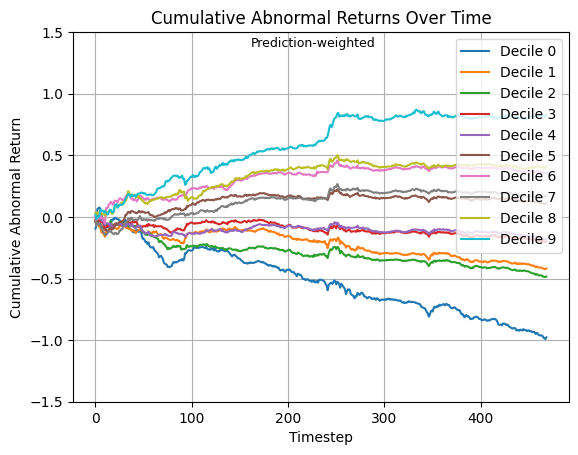

In [28]:
predictions = []
variables = ['ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment']
df = convert_to_df(all_data)
df = sanitize_input(add_invalid_label_mask(df))
block_idxs = chronological_sampling_scheme(469, [1,1,1])
for identifier in identifier_list:
    model_predicition = []
    for i in range(3):
        test_idx = block_idxs[i]
        curr_model = torch.load(f'{rootdir}model{i}{identifier}')
        curr_input = get_tensor_from_df(df[df['Timestep'].isin(test_idx)], variables, False)
        model_predicition.append(curr_model.predict(curr_input))
    model_output = torch.cat(model_predicition, dim=0)
    predictions.append(model_output)
ensemble_pred = get_mean_elementwise(predictions).detach().numpy()
df['prediction'] = ensemble_pred.flatten()
new_df_valid = df[df['mask']].copy()
new_df_valid = shitty_algo(new_df_valid)
new_df_monthly_return = calculate_month_return(new_df_valid)
plot_returns(new_df_monthly_return, method='sum', pred_weight=True, savedir=savedir)
